# Integrated Project 2: Gold Mining
***

In this project we will be training machine learning algorithms to predict the amount of gold that will be recovered from raw gold ore for the heavy industry solutions company Zyfra. They have provided 3 raw CSV datasets from their data warehouse each named:

- `gold_recovery_full.csv`
- `gold_recovery_train.csv`
- `gold_recovery_test.csv`

The data has already been split into training and test datasets, while `gold_recovery_full.csv` contains all entries. We will first assess the data for accuracy, then preform preliminary analysis to ensure the accuracy of the various models that will be tested. The company has asked that we use the symmetric Mean Absolute Percentage Error (sMAPE) metric to ensure the validity of the models, the formula for which will be described later in the notebook.

Once the data has been assessed and metrics calculated, 4 different learning models will be trained and evaluated using the new metric including:

- `LinearRegression`
- `DecisionTreeRegressor`
- `KNeighborsRegressor`
- `RandomForestRegressor`

The model with the best average score after cross evaluating the training dataset will be used on the test dataset to ensure the model still preforms well with new data.

## Loading Data

First all necessary libraries will be imported, then the datasets will be loaded.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

Loading datasets into DataFrames named `df`, `df_train` and `df_test` respectively.

In [2]:
# Loading data
df = pd.read_csv('gold_recovery_full.csv')
df_train = pd.read_csv('gold_recovery_train.csv')
df_test = pd.read_csv('gold_recovery_test.csv')

# Displaying info 
df.info()
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


The full dataset contains 22716 entries and 87 columns, the data from both the training set and test set. The data includes parameters that were measured and/or calculated later in the process, which will be excluded from the training data, which has 16860 entries and also 87 columns.

The test dataset has the remaining 5856 entries and only 53 columns including the `date` column that serves as the index value for the data. 

The columns are grouped by the stage of the cleaning process:
1. `rougher` — flotation
2. `primary_cleaner` — primary purification
3. `secondary_cleaner` — secondary purification
4. `final` — final characteristics

The stages are then further split into parameter types:
1. `input` — raw material parameters
2. `output` — product parameters
3. `state` — parameters characterizing the current state of the stage
4. `calculation` — calculation characteristics

After the stage and parameter type is the parameter name including `concentrate`, `tail` and `floatbank` parameters.

## Data Preprocessing

The 53 columns in the test dataset will be saved to train the ML algorithms.

In [3]:
# Saving feature_names
feature_names = list(df_test.columns)
display(len(feature_names))
display(feature_names)

53

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In order to ensure the models are trained only on relevant data, all rows missing target values will be removed.

In [4]:
# Removing missing target values
targets = ['rougher.output.recovery', 'final.output.recovery']
if set(targets).issubset(df_train.columns):
    df_train = df_train.dropna(subset=targets)
if set(targets).issubset(df_test.columns):
    df_test = test_data.dropna(subset=targets)
if set(targets).issubset(df.columns):
    df = df.dropna(subset=targets)

Due to the nature of the data, parameters that are next to each other in terms of time are often similar. Using this information, we will use the `ffill` method of the `fillna` function to fill the remaining missing data.

In [5]:
# Filling remaining missing values
df = df.ffill()
df_train = df_train.ffill()
df_test = df_test.ffill()
print(df.isna().sum().sum(), df_train.isna().sum().sum(), df_test.isna().sum().sum())

0 0 0


Checking for duplicates to ensure accuracy:

In [6]:
print(df.duplicated().sum(), df_train.duplicated().sum(), df_test.duplicated().sum())

0 0 0


The customer has requested that the `rougher.output.recovery` value be verified for accuracy. In order to do this, I will write a program that calculates the recovery according to the formula: 

$$
Recovery = \frac{C * (F - T)}{F * (C - T)} * 100\%
$$

Where:
- C = share of gold in the concentrate right after flotation
- F = share of gold in the feed before flotation
- T = share of gold in the rougher tails right after flotation

After that, a program that calculates the Mean Absolute Error of the previous program's calculations will be written, then both will be used.

In [7]:
# Setting variable names for recovery calculation
rougher_var = ['rougher.output.concentrate_au',
               'rougher.input.feed_au',
               'rougher.output.tail_au',
               'rougher.output.recovery'] 

# Writing a function to calculate recovery
def calculate_recovery(data, var_names):
    
    c = data[var_names[0]]
    f = data[var_names[1]]
    t = data[var_names[2]]
    
    num = c * (f - t)
    denom = f * (c - t)
    recovery = (num/denom) * 100
    
    return recovery

# Writing a function to calculate MAE of recovery
def calculate_mae(data, var_names):
    
    predicted_recovery = calculate_recovery(data, var_names)
    recorded_recovery = data[var_names[3]]
    mae = mean_absolute_error(recorded_recovery, predicted_recovery)
    return mae


rougher_mae = calculate_mae(df_train, rougher_var)
display(f'Mean Abolute Error for rougher.output.recovery: {rougher_mae}')

'Mean Abolute Error for rougher.output.recovery: 9.317053768151204e-15'

The MAE for the recovery is $9.32 * 10 ^{-15}$, showing that the error is very small, verifying the accuracy of the data.

## Data Analysis

Now that the data has been cleaned and verified for accuracy, we will plot a few graphs to ensure that the models don't run into any issues before training begins.

The following graph looks at the concentration levels of all metals at each stage of the purification process:

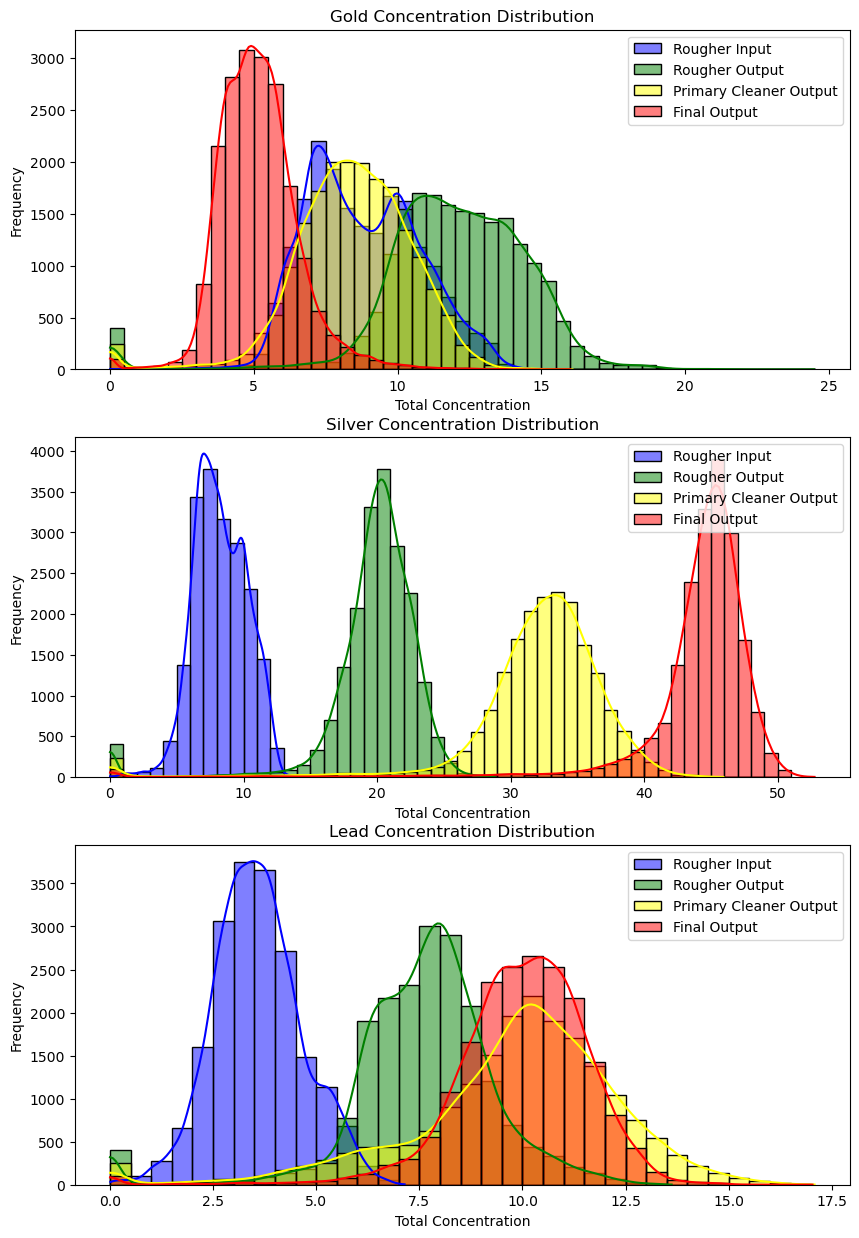

In [8]:
# Isolating metal concentration values
ag_concentration = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
au_concentration = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
pb_concentration = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
color_map = ['blue', 'green', 'yellow', 'red']
labels = ['Rougher Input', 'Rougher Output', 'Primary Cleaner Output', 'Final Output']

# Plotting histograms
plt.figure(figsize=(10,15))

ag_bins = np.arange(0, 25, .5)
plt.subplot(3, 1, 1)
for i in range(len(ag_concentration)):
    sns.histplot(df[ag_concentration[i]], bins=ag_bins, kde=True, label=labels[i], color=color_map[i])
plt.legend(loc='upper right')
plt.title('Gold Concentration Distribution')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')

au_bins = np.arange(0, 52, 1)
plt.subplot(3, 1, 2)
for i in range(len(au_concentration)):
    sns.histplot(df[au_concentration[i]], bins=au_bins, kde=True, label=labels[i], color=color_map[i])
plt.legend(loc='upper right')
plt.title('Silver Concentration Distribution')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')

pb_bins = np.arange(0, 17.5, .5)
plt.subplot(3, 1, 3)
for i in range(len(pb_concentration)):
    sns.histplot(df[pb_concentration[i]], bins=pb_bins, kde=True, label=labels[i], color=color_map[i])
plt.legend(loc='upper right')
plt.title('Lead Concentration Distribution')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')

plt.show()

This graph shows that as the raw material reaches each new purification step the concentration of metals gradually increases, however at all steps there are values of 0, most significantly the Rougher Output step. 

The next histogram compares the `feed_size` columns in the train and test dataset for the `rougher` stage and the `primary_cleaner` stage respectively. This ensures that the training and test datasets have similar distrubutions to ensure the model can make accurate predictions.

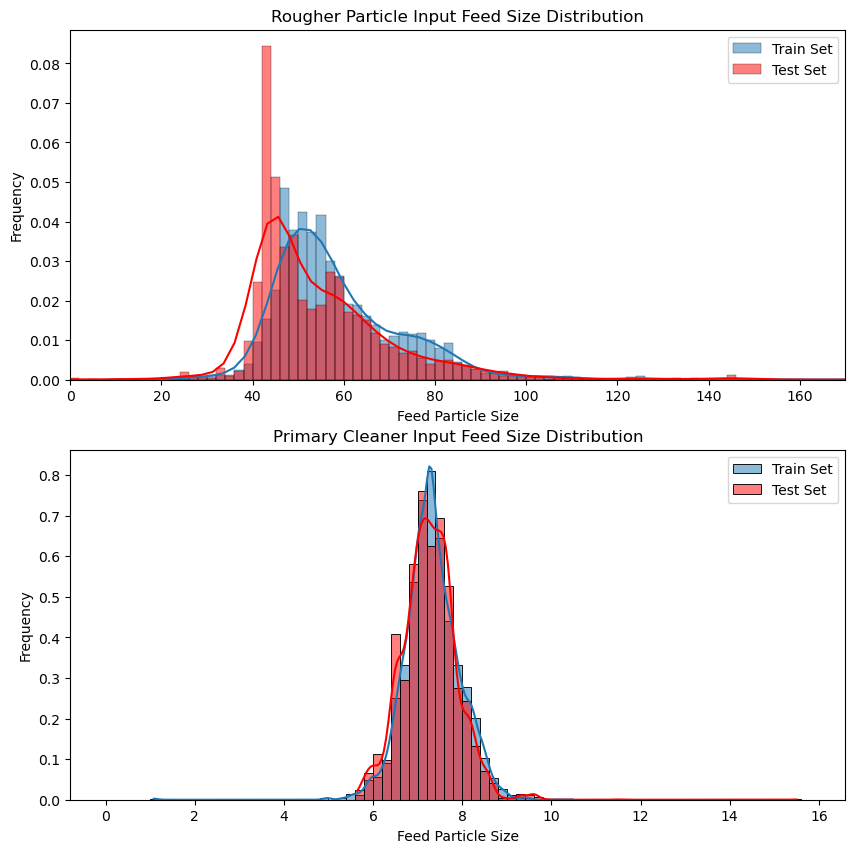

In [9]:
# Selecting feed_size columns
feed_size = [col for col in df_train if 'feed_size' in col]

# Create figure for plots
plt.figure(figsize=(10,10))

# Histogram for Rougher Feed Size
rougher_bins = np.arange(0, 150, 2)
plt.subplot(2, 1, 1)
sns.histplot(df_train[feed_size[1]], bins=rougher_bins, kde=True, label='Train Set', stat='density')
sns.histplot(df_test[feed_size[1]], bins=rougher_bins, kde=True, label='Test Set', color='red', stat='density')
plt.legend(loc='upper right')
plt.xlim(0, 170)
plt.title('Rougher Particle Input Feed Size Distribution')
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency')

# Histogram for Primary Cleaner Feed Size
cleaner_bins = np.arange(0, 16, 0.2)
plt.subplot(2, 1, 2)
sns.histplot(df_train[feed_size[0]], bins=cleaner_bins, kde=True, label='Train Set', stat='density')
sns.histplot(df_test[feed_size[0]], bins=cleaner_bins, kde=True, label='Test Set', color='red', stat='density')
plt.legend(loc='upper right')
plt.title('Primary Cleaner Input Feed Size Distribution')
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency')

plt.show()

The Rougher Feed Size datasets both have a similar mean with a similar skew to the right.

The Primary Cleaner Feed Size datasets both have a more normal distribution with a mean of approximately 7.5.

The plot clearly shows that both datasets have similiar `feed_size` distributions, therefore the algorithms can be tested on this data.

The final graph looks at the total concentration of all substances at all stages:

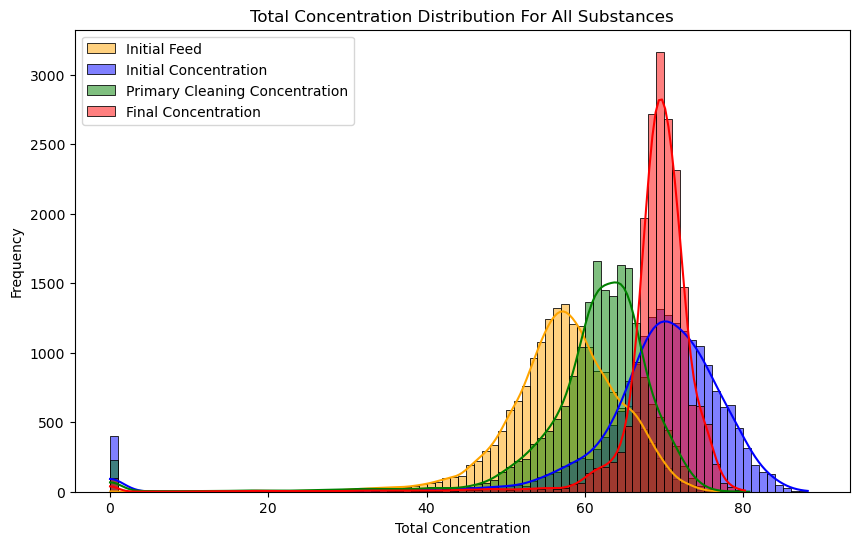

In [10]:
# Selecting the stages
rougher_input = ['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher_concentrate = [col for col in df_train if 'rougher.output.concentrate' in col]
primary_concentrate = [col for col in df_train if 'primary_cleaner.output.concentrate' in col]
final_concentrate = [col for col in df_train if 'final.output.concentrate' in col]

# Plotting histograms
binz = np.arange(0, 90, 1)
plt.figure(figsize=(10, 6))
sns.histplot(df[rougher_input].sum(axis=1), bins=binz, kde=True, color='orange', label='Initial Feed', alpha=.5)
sns.histplot(df[rougher_concentrate].sum(axis=1), bins=binz, kde=True, color='blue', label='Initial Concentration', alpha=.5)
sns.histplot(df[primary_concentrate].sum(axis=1), bins=binz, kde=True, color='green', label='Primary Cleaning Concentration', alpha=.5)
sns.histplot(df[final_concentrate].sum(axis=1), bins=binz, kde=True, color='red', label='Final Concentration', alpha=.5)

# Labeling plot
plt.title('Total Concentration Distribution For All Substances')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This graph shows an abnormal amount of 0 values in all of the stages with the exception of Initial Feed. The outliers will be kept in the dataset as even if certain stages have low output, there is still ore elsewhere in the purification process.

## Preparing for Training

Zyfra wants the models to be trained on the symmetric Mean Absolute Percentage Error (sMAPE) metric, which is calculated via the following formula:

$$
sMAPE = \frac{1}{N} \sum_{i=1}^N \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\%
$$

Where:
- $N$ = Number of observations
- $y_i$ = Target Value
- $\hat{y_i}$ = Predicted Value
- $i$ = Index Value

The models will be predicting 2 separate values, `'rougher.output.recovery'` and `'final.output.recovery'`.

The final sMAPE value for each model is calculated via the following formula:

Final sMAPE = (25% * sMAPE(rougher) + (75% * sMAPE(final))

A function that calculates both the rougher sMAPE and final sMAPE and then combines them as required. Then the function will be used with the `make_scorer` function from sklearn so that the models can be cross validated.

In [11]:
# Defining a function to calculate the sMAPE metric
def smape(target, pred):
    N = len(target)
    smape = (1 / N) * np.sum(2 * np.abs(pred - target) / (np.abs(target) + np.abs(pred))) * 100
    final_smape = (smape[0] * .25) + (smape[1] * .75)
    return final_smape

# Defining the scorer for the cross_val_score function 
smape_scorer = make_scorer(smape, greater_is_better=False)

Now the data will be split into features and targets to fully prepare the data for training and final testing.

The `feature_names` variable will be used to select only the features avalible in the test dataset and the `date` column is dropped as the data is not relevant for our purposes. 

The `targets` variable will be used to select the targets for the learning algorithms, however the test dataset is missing the target values. This is corrected by merging the test dataset and the full dataset via the `date` column then selecting the targets from the new DataFrame.

In [12]:
# Training data
features_train = df_train[feature_names].drop('date', axis=1)
target_train = df_train[targets] 

# Test data
features_test = df_test[feature_names].drop('date', axis=1)
df_test_target = pd.merge(df_test, df[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')
target_test = df_test_target[targets]

display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(14149, 52)

(14149, 2)

(5856, 52)

(5856, 2)

## Training models

We will now train and validate the models using the `cross_val_score` function, using the `smape_scorer` that was created earlier as the evaluation metric. 

The average of the smape values is displayed, then the model that preformed the best in cross validation will be used for the final test.

In [13]:
linereg = LinearRegression()
trial_score = -cross_val_score(linereg, features_train, target_train, cv=5, scoring=smape_scorer).mean()
display(f'Average sMAPE: {trial_score.mean()}')

'Average sMAPE: 12.384596104847033'

The Linear Regression model had a mean sMAPE of 12.385.

In [14]:
top_neighbor_score = 100
best_neigh_num = 0
for n in range(20, 401, 20):
    k_model = KNeighborsRegressor(n_neighbors=n)
    k_score = -cross_val_score(k_model, features_train, target_train, cv=5, scoring=smape_scorer).mean()
    if k_score < top_neighbor_score:
        top_neighbor_score = k_score
        top_model = k_model
        best_neigh_num = n
display(f'Best Number of Neighbors: {best_neigh_num} - sMAPE: {top_neighbor_score}')

'Best Number of Neighbors: 400 - sMAPE: 11.446089348797853'

The best K-Neighbors Regressor had 400 neighbors and a mean sMAPE of 11.446.

In [15]:
top_tree_score = 100
top_depth = 0
for depth in range(1, 11):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=888)
    tree_score = -cross_val_score(tree, features_train, target_train, cv=5, scoring=smape_scorer).mean()
    if tree_score < top_tree_score:
        top_tree_score = tree_score
        top_tree = tree
        top_depth = depth
display(f'Best Depth: {top_depth} - sMAPE: {top_tree_score}')

'Best Depth: 4 - sMAPE: 11.008386560119698'

The best Decision Tree Regressor model had a depth of 4 with a mean sMAPE of 11.008, preforming better than both of the previous models.

In [17]:
top_forest_score = 100
best_est = 0
forest_depth = 0

for depth in range(1, 10):
    for est in range(10, 101, 10):
        forest = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=888)
        forest_score = -cross_val_score(forest, features_train, target_train, cv=5, scoring=smape_scorer).mean()
        if forest_score < top_forest_score:
            top_forest_score = forest_score
            top_forest = forest
            forest_depth = depth
display(f'Best Depth: {forest_depth} - sMAPE: {top_forest_score}')

'Best Depth: 6 - sMAPE: 10.334911901115918'

The best Random Forest Regressor model had a depth of 6 and a mean sMAPE of 10.335, preforming the best out of all the models.

## Final Test

Now the best preforming model, the Random Forest Regressor, will be used for the final test using the test dataset.

In [18]:
# Final Test
top_forest.fit(features_train, target_train)
test_predict = top_forest.predict(features_test)
test_score = smape(target_test, test_predict)
display(f'Test sMAPE: {test_score}')

# Preforming Sanity Check
sanity = np.array([target_test.median() for i in target_test.index])
sanity_check = smape(target_test, sanity)
display(f'Sanity Check: {sanity_check}')

'Test sMAPE: 8.219471398935315'

'Sanity Check: 8.030300192954662'

The best model preformed exceedingly well with the test dataset, with an sMAPE score of 8.220.

The models have been succesfully trained with errors being minimized.